<h1> Predicting Speed: A Statistical Analysis of the Biomechanical Features in Rowing </h1>

This notebook was used to collect, clean and analyze a dataset of 115 races done between the Princeton Heavyweight rowing team during their annual training camp in Tampa. Five predictive models were run to analyze the ability to predict race outcomes and feature contribution of certain biomechnical variables computed by PowerlineTM. 

This notebook contains the following subchapters: 
> * [Extract Data](#Extract-Data) 
> * [Clean Data](#Clean-Data) 
> * [Computed Variables](#Computed-Variables) 
> * [Correlation and Dependency Plots](#Correlation-and-Dependency-Plots) 
> * [Outlier Analysis](#Outlier-Analysis)  
> * [Feature Selection](#Feature-Selection) 
> * [MODEL #1: OLS REGRESSION ](#MODEL-#1:-OLS-REGRESSION )
> * [MODEL #2 LASSO REGRESSION](#MODEL-#2-LASSO-REGRESSION)
> * [MODEL #3: DECISION TREE](#MODEL-#3:-DECISION-TREE)
> * [MODEL #4: EXTREME GRADIENT BOOSTED TREE](#MODEL-#4:-EXTREME-GRADIENT-BOOSTED-TREE)
> * [MODEL #5 NEURAL NETWORK](#MODEL-#5-NEURAL-NETWORK)
> * [Prediction Accuracy](#Prediction-Accuracy)
> * [Correlation Observations](#Correlation-Observations)
> * [Force Curve Analysis](#Force-Curve-Analysis)
> * [Feature Importance](#Feature-Importance)







In [1]:
import numpy as np 
import pandas as pd 

from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import NaN
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
import seaborn
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2, r_regression
from xgboost import plot_tree
from sklearn import tree

# progress bar imports 
import time
from tqdm import tqdm

# ML models 
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

#Plot layouts 
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
style.use('seaborn')
plt.rc("figure", figsize=(16, 8))
seaborn.set(font_scale=1.8) 

# Extract Data

In [2]:
xls = pd.ExcelFile('Tampa_data_3.0.xlsx')
sheets = xls.sheet_names

In [3]:
d = {}
aper = {}
per = {}

for point in tqdm(range(0, 115)): 
    d[sheets[point]] = pd.read_excel('Tampa_data_3.0.xlsx', sheet_name = point)

    ######## Extract aperiodic data #########
    start_aper = d[sheets[point]][d[sheets[point]].iloc[:, 2] == "0x800A"].index[0] + 1
    end_aper   = d[sheets[point]][d[sheets[point]].iloc[:, 2] == "0x8001"].index[0]

    aperiodic = d[sheets[point]].iloc[start_aper:end_aper, :]

    # Create Multi Header for aperiodic dataframe
    header = [aperiodic.iloc[0].to_numpy(), aperiodic.iloc[1].to_numpy()]
    aperiodic.columns = header
    aperiodic = aperiodic.drop(aperiodic.index[0:3])
    # add margin to dataframe 
    aperiodic['Margin'] = int(d[sheets[point]].columns[3])
    aper[sheets[point]] = aperiodic
    
    
    ########### extract periodic data #########
    start_per = d[sheets[point]][d[sheets[point]].iloc[:, 1] == "Periodic"].index[0] + 1
    
    periodic = d[sheets[point]].iloc[start_per:, :32]
    
    # Create Multi Header for periodic dataframe
    header = [periodic.iloc[0].to_numpy(), periodic.iloc[1].to_numpy()]
    periodic.columns = header
    periodic = periodic.drop(periodic.index[0:3])
    
    per[sheets[point]] = periodic
       

100%|█████████████████████████████████████████| 115/115 [05:37<00:00,  2.94s/it]


In [4]:
per['20_01_31_#1_b1']

Time GateAngle                                               \
           NaN         1        2        3        4        5        6   
243     747800  -57.9375 -59.8125 -60.9375 -55.8125  -57.875 -53.8125   
244     747820  -58.4375 -59.5625 -60.6875 -56.3125  -58.125 -54.0625   
245     747840  -58.4375 -59.3125 -60.4375 -56.3125  -58.125   -56.25   
246     747860  -58.4375 -59.3125 -60.9375 -56.3125  -58.375 -59.0625   
247     747880  -58.9375 -58.3125 -60.9375   -55.25  -58.375 -58.5625   
...        ...       ...      ...      ...      ...      ...      ...   
14936  1041660   -43.625 -47.5625 -43.0625  -43.875 -44.0625 -42.4375   
14937  1041680  -42.3125  -45.625   -41.25   -42.25 -42.3125 -40.4375   
14938  1041700  -40.6875 -43.8125 -39.3125 -40.4375 -40.8125  -38.625   
14939  1041720   -38.625  -42.125 -37.6875 -38.3125 -38.9375 -36.5625   
14940  1041740    -36.75      -40    -35.5 -36.4375 -37.1875  -34.375   

                        GateForceX  ... GateAngleVel                         \
             7        8          1  ...            6           7          8   
243      -62.5      -57    14.3125  ...   -47.760414  -12.499999 -32.708332   
244   -60.6875 -57.9375    17.3125  ...   -38.645828     7.65625 -24.739582   
245   -59.0625  -58.125    16.8125  ...   -19.635414   26.093748 -15.260415   
246      -62.5  -58.375    17.8125  ...    13.541667    49.21875  -4.322917   
247   -60.1875  -58.125    16.8125  ...    52.447914   75.052078  12.239583   
...        ...      ...        ...  ...          ...         ...        ...   
14936 -41.0625 -48.4375     36.875  ...   115.901527   117.93306  90.272964   
14937    -39.5 -46.5625    42.9375  ...   113.661636  107.410767  90.741783   
14938 -37.5625  -44.875    47.1875  ...   110.015305   99.076279  91.939873   
14939   -35.25      -43    51.5625  ...   106.421036   99.545082  93.710938   
14940  -33.375 -41.1875      55.25  ...   107.306572  102.930969  95.846649   

          Speed Distance     Accel Roll Angle Pitch Angle Yaw Angle  \
           Boat     Boat      Boat       Boat        Boat      Boat   
243   -0.601563        0 -5.390625      -0.25   -0.734375   -0.4375   
244   -0.714844        0 -6.429688  -0.265625   -0.609375   -0.4375   
245   -0.835938        0 -7.023438  -0.296875    -0.46875 -0.453125   
246   -0.941406        0 -6.265625    -0.1875     -0.3125  -0.46875   
247   -1.074219        0 -7.832031     -0.125   -0.203125   -0.4375   
...         ...      ...       ...        ...         ...       ...   
14936 -1.441406        0 -1.265625   1.078125    0.421875  0.046875   
14937 -1.394531        0  0.378906     0.9375    0.421875  0.046875   
14938 -1.355469        0  0.070313       0.75    0.421875  0.046875   
14939   -1.3125        0  0.460938   0.578125    0.421875  0.046875   
14940 -1.277344        0 -0.054688    0.40625    0.421875  0.046875   

      Normalized Time  
                 Boat  
243             -12.5  
244        -11.458336  
245        -10.416664  
246            -9.375  
247         -8.333336  
...               ...  
14936        -1.03093  
14937               0  
14938               1  
14939               2  
14940               3  

[14698 rows x 32 columns]

Text(0.5, 1.0, '6 strokes over time')

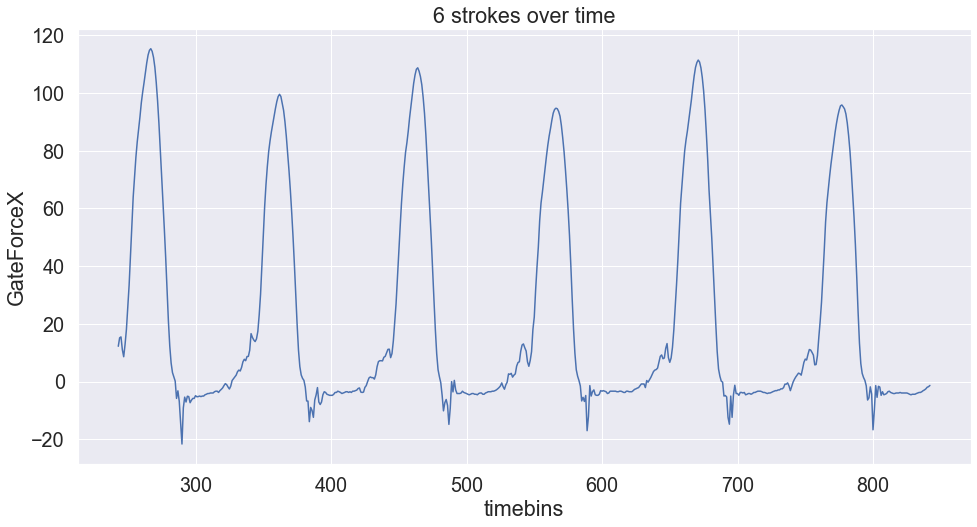

In [5]:
plt.plot(per['20_01_31_#1_b1'].GateForceX[3][:600])
plt.xlabel('timebins')
plt.ylabel('GateForceX')
plt.title('6 strokes over time')

# Clean data

In [6]:
%%capture 
data = aper[sheets[0]].mean(axis = 0).to_frame().T

for point in range(1, 115):    
    data = data.append(aper[sheets[point]].mean(axis = 0).to_frame().T) # aperiodic 
    
# remove duplicate columns 
data = data.drop(columns = ['Rower Swivel Power', 'AvgBoatSpeed', 'Dist/Stroke', 'StrokeNumber', 'Chanb885', 'Average Power'])
data = data.reset_index(drop = True)

In [7]:
data

Time SwivelPower                                                  \
              NaN           1           2           3           4           5   
0    8.953337e+05  269.136986  352.164384  286.897260  280.500000  309.876712   
1    4.339693e+05  294.224490  325.653061  294.510204  269.204082  382.061224   
2    3.177188e+05  319.380952  328.386905  315.964072  312.976190  391.839286   
3    1.007475e+06  363.958333  305.312500  313.208333  338.048611  387.368056   
4    4.407041e+05  379.417808  302.369863  321.945205  351.301370  341.390411   
..            ...         ...         ...         ...         ...         ...   
110  1.506219e+06  300.064935  322.603896  368.267974  351.058442  328.590909   
111  2.283009e+06  285.782051  302.320513  350.006410  326.961538  339.660256   
112  3.470983e+05  308.963636  296.903030  359.103030  323.672727  360.181818   
113  1.115976e+06  304.872727  296.363636  333.387879  314.048485  347.987879   
114  2.278963e+05  318.012048  300.095808  366.656627  326.167665  343.988024   

                                          MinAngle  ... Max Force PC  \
              6           7           8          1  ...            1   
0    335.184932  376.020548  348.184932 -62.500000  ...    42.018168   
1    410.163265  389.557823  343.646259 -62.864371  ...    44.564360   
2    409.761905  412.797619  348.142857 -63.126116  ...    43.045468   
3    372.979167  345.159722  381.944444 -54.556858  ...    55.089254   
4    338.000000  329.979452  377.712329 -54.690068  ...    54.706449   
..          ...         ...         ...        ...  ...          ...   
110  353.474026  397.155844  355.542484 -56.559659  ...    41.605537   
111  352.057692  393.782051  420.064516 -56.307692  ...    43.810253   
112  331.557576  405.103030  401.703704 -55.032576  ...    47.450306   
113  311.866667  392.951515  365.256098 -55.254924  ...    45.353347   
114  326.275449  385.910180  353.077844 -55.772829  ...    45.986794   

                                                                       \
             2          3          4          5          6          7   
0    44.462814  47.602118  45.504967  55.737604  55.696278  53.737653   
1    43.904106  48.959850  45.373718  44.306648  46.583853  54.586057   
2    43.866659  48.039489  43.813454  34.965937  45.003007  54.860408   
3    64.605937  45.149147  46.114532  45.069831  54.505690  53.337734   
4    64.713908  43.868458  45.225128  56.111350  57.203087  52.287244   
..         ...        ...        ...        ...        ...        ...   
110  49.158045  41.182503  42.661845  49.660834  44.934141  51.938758   
111  47.241241  39.323983  42.535455  50.128592  50.389752  52.017400   
112  48.468135  42.071106  41.212927  49.126320  47.315487  51.089883   
113  42.860971  37.500421  40.181444  57.577422  45.530793  50.405868   
114  46.096751  48.615593  40.119361  57.335542  43.518042  50.303244   

                   Rating Margin  
             8       Boat         
0    48.736637  29.417808  -12.0  
1    51.294077  29.363946    4.0  
2    50.449525  33.502976    2.0  
3    55.340914  28.621528   12.0  
4    54.614231  29.270548   -4.0  
..         ...        ...    ...  
110  49.333367  30.990260    5.0  
111  49.978705  30.910256   -5.0  
112  50.884936  33.166667    3.0  
113  51.245761  33.021212   -6.0  
114  51.081143  33.026946    6.0  

[115 rows x 123 columns]

In [8]:
# Compute mean of sublevels 
boat_avg = data.copy() 
boat_avg.MinAngle = boat_avg.MinAngle.mean(axis = 1)
boat_avg.CatchSlip = boat_avg.CatchSlip.mean(axis = 1)
boat_avg.MaxAngle = boat_avg.MaxAngle.mean(axis = 1)
boat_avg.FinishSlip = boat_avg.FinishSlip.mean(axis = 1)
boat_avg['Drive Start T'] = boat_avg['Drive Start T'].mean(axis = 1)
boat_avg['Drive Time'] = boat_avg['Drive Time'].mean(axis = 1)
boat_avg['Recovery Time'] = boat_avg['Recovery Time'].mean(axis = 1)
boat_avg['Angle Max F'] = boat_avg['Angle Max F'].mean(axis = 1)
boat_avg['Angle 0.7 F'] = boat_avg['Angle 0.7 F'].mean(axis = 1)
boat_avg['Work PC Q1'] = boat_avg['Work PC Q1'].mean(axis = 1)
boat_avg['Work PC Q2'] = boat_avg['Work PC Q2'].mean(axis = 1)
boat_avg['Work PC Q3'] = boat_avg['Work PC Q3'].mean(axis = 1)
boat_avg['Work PC Q4'] = boat_avg['Work PC Q4'].mean(axis = 1)
boat_avg['Max Force PC'] = boat_avg['Max Force PC'].mean(axis = 1)
boat_avg['SwivelPower'] = boat_avg['SwivelPower'].mean(axis = 1)
# Remove sublevel duplicates
boat_avg = boat_avg.T.drop_duplicates().T

# Drop sublevel entirely 
boat_avg.columns = boat_avg.columns.get_level_values(0)

# add index to dataframe 
boat_avg = boat_avg.reset_index(drop = True)

# Computed Variables

capture effects for:
* Synchronicity 
* Stability 
* Smoothness

In [9]:
%%capture 

###################################### STABILITY ############################################### 

# add roll, pitch and yaw values and first vs second group
boat_avg['group'] = 1
boat_avg[['Roll std','Pitch std','Yaw std']] = np.nan

for i in range(0, 115):
    if 'b3' in sheets[i]: 
        boat_avg['group'][i] = 2
    if 'b4' in sheets[i]:
        boat_avg['group'][i] = 2
    if 'Roll Angle' in per[sheets[i]]:
        boat_avg['Roll std'][i] = per[sheets[i]]['Roll Angle'].std()
    if 'Pitch Angle' in per[sheets[i]]:
        boat_avg['Pitch std'][i] = per[sheets[i]]['Pitch Angle'].std()
    if 'Yaw Angle' in per[sheets[i]]:
        boat_avg['Yaw std'][i] = per[sheets[i]]['Yaw Angle'].std()
        


###################################### SYNCRHONICITY ############################################

boat_avg['Drive Start T std'] = data['Drive Start T'].std(axis = 1)
boat_avg['Drive Time std'] = data['Drive Time'].std(axis = 1)
boat_avg['Recovery Time std'] = data['Recovery Time'].std(axis = 1)
boat_avg['Max Force PC std'] = data['Max Force PC'].std(axis = 1)
boat_avg['CatchSlip std'] = data['CatchSlip'].std(axis = 1)
boat_avg['Power std']     = data['SwivelPower'].std(axis = 1)



######################################### SMOOTHNESS ##############################################
###### Force Curve Variance #####
boat_avg[['Curve Asymmetry']] = np.nan
boat_avg[['Curve Smoothness']] = np.nan

myline = np.linspace(-50, 20, 100) # -60, 27
curve = np.zeros((115, 8, 100))
smoothness = np.zeros((115, 8))

for i in range(0, 115):
    
    ### Compute curve symmetry score for piece i (all available seats) ###
    for j in per[sheets[i]].GateForceX:

        idx = np.where(per[sheets[i]].GateForceX[j].to_numpy().flatten().astype(float) > 10)
        x = per[sheets[i]].GateAngle[j].to_numpy().flatten().astype(float)[idx]
        y = per[sheets[i]].GateForceX[j].to_numpy().flatten().astype(float)[idx]

        # outlier treatment (drop outliers from x and y)
        idx_nan = np.logical_and(x > -50, x < 20) & np.logical_and(y > -50, y < 190)
        x = x[idx_nan]; y = y[idx_nan]

        # run 7-degree polynomial
        mymodel = np.poly1d(np.polyfit(x, y, 6))
        curve[i][j-1] = mymodel(myline)
        
        # Compute derivate of polynomial and compute smoothness 
        der = np.polyder(mymodel, m = 1)
        smoothness[i][j-1] = 1/der(myline).std().astype(float)
    
    
    ### Assign to Curve Assymetry ###
    boat_avg['Curve Asymmetry'][i] = np.mean( np.abs(np.mean((curve[i]), axis=0) - curve[i]) )
    
    ### Assign Smoothness score 
    boat_avg['Curve Smoothness'][i] = np.mean(smoothness[i])


# Correlation and Dependency Plots

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


/Users/jelmerbennema/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/regressionplots.py:565: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


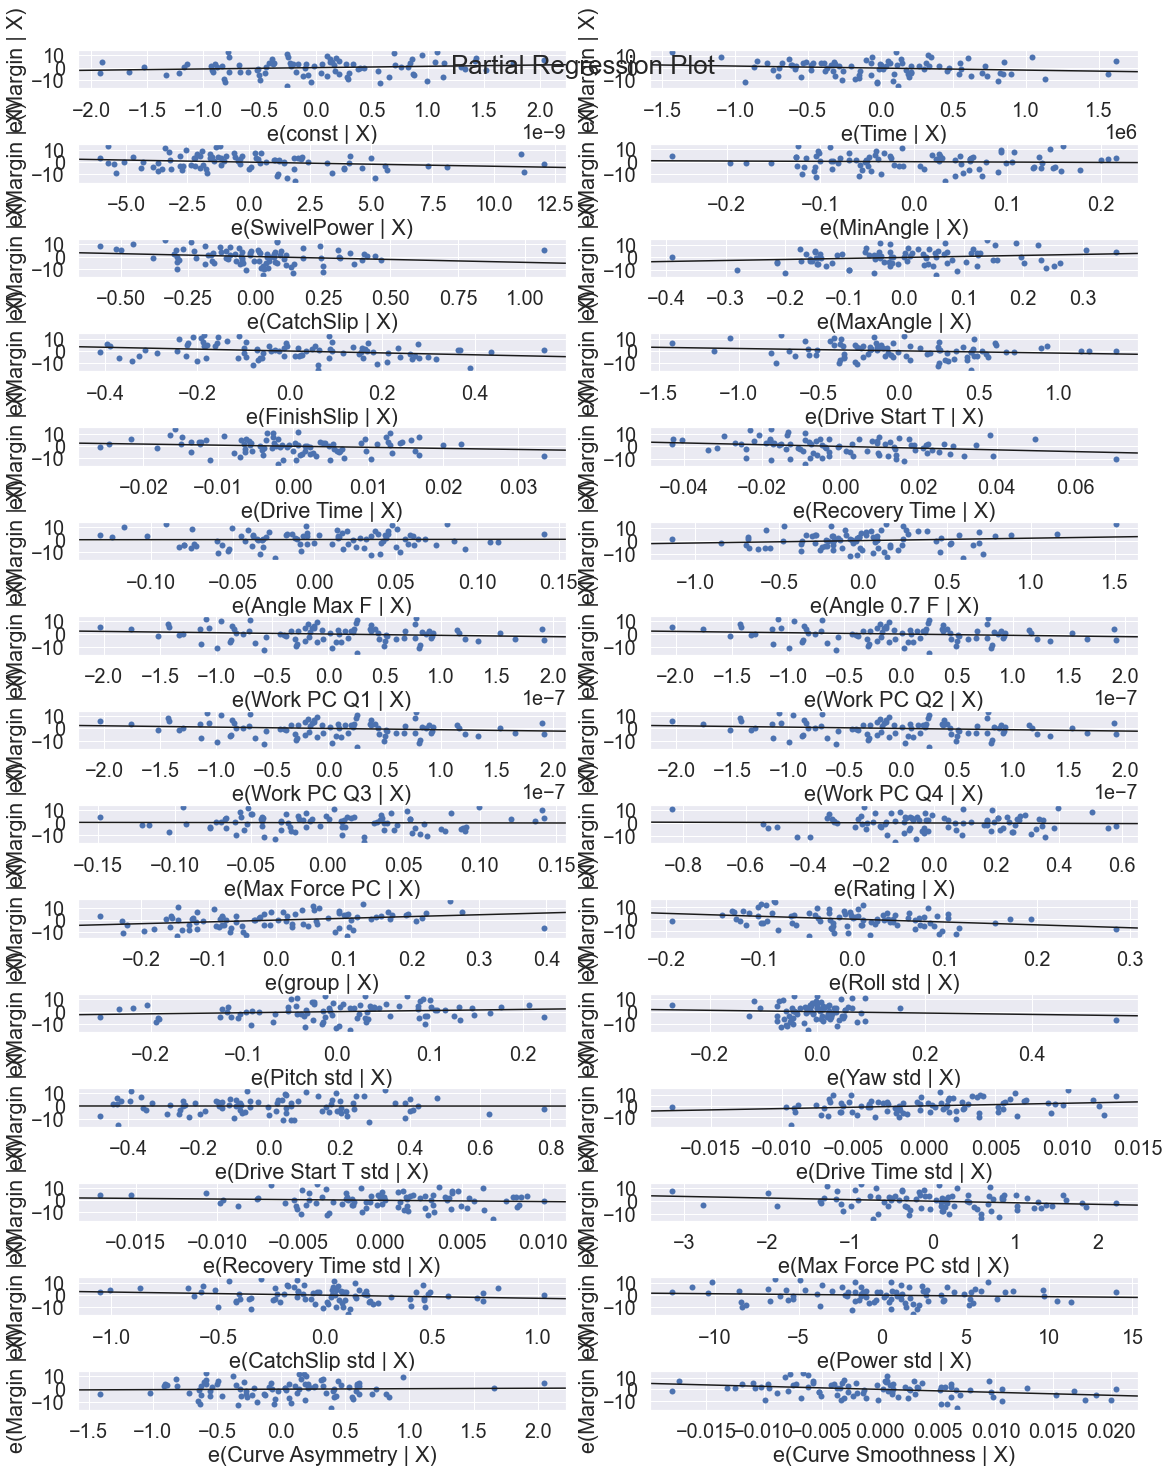

In [10]:
# partial regression plot 
x =  boat_avg.loc[:, boat_avg.columns != 'Margin']
x = sm.add_constant(x)
y = boat_avg.Margin

model = sm.OLS(y, x, missing='drop').fit()
fig = sm.graphics.plot_partregress_grid(model)
fig.set_figheight(20)
fig.tight_layout(pad=0.0)
seaborn.set(font_scale=0.9)
#plt.show()
plt.savefig('partial.pdf')

In [11]:
seaborn.set(font_scale=1.8)

In [12]:
corr = boat_avg.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_properties(**{'font-size': '10pt'})

/var/folders/31/fstssryx6fz79_8yk16n79tw0000gn/T/ipykernel_55624/2705951240.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_properties(**{'font-size': '10pt'})


,Time,SwivelPower,MinAngle,CatchSlip,MaxAngle,FinishSlip,Drive Start T,Drive Time,Recovery Time,Angle Max F,Angle 0.7 F,Work PC Q1,Work PC Q2,Work PC Q3,Work PC Q4,Max Force PC,Rating,Margin,group,Roll std,Pitch std,Yaw std,Drive Start T std,Drive Time std,Recovery Time std,Max Force PC std,CatchSlip std,Power std,Curve Asymmetry,Curve Smoothness
Time,1.00,0.10,-0.13,-0.16,0.24,0.08,0.14,0.11,-0.04,-0.03,-0.21,0.19,-0.07,-0.12,0.01,-0.05,0.07,-0.01,-0.12,-0.29,-0.30,-0.16,0.08,-0.04,0.14,-0.02,-0.05,0.04,-0.05,0.04
SwivelPower,0.10,1.00,-0.47,0.04,0.50,-0.07,-0.43,-0.40,-0.26,0.13,0.21,-0.35,-0.13,0.30,0.19,0.17,0.38,0.17,-0.84,0.08,0.34,0.13,-0.24,-0.04,0.03,0.02,-0.17,0.20,0.32,-0.57
MinAngle,-0.13,-0.47,1.00,-0.45,-0.38,0.22,-0.19,-0.10,-0.29,-0.16,-0.05,0.66,0.34,-0.57,-0.46,-0.40,0.26,-0.14,0.51,0.20,-0.04,-0.12,0.23,-0.13,0.05,0.18,0.25,-0.00,-0.46,0.41
CatchSlip,-0.16,0.04,-0.45,1.00,-0.00,-0.11,-0.09,-0.01,0.14,0.34,0.59,-0.81,-0.16,0.63,0.35,0.47,-0.13,-0.07,-0.07,0.33,0.41,0.15,-0.12,0.24,0.08,-0.26,-0.18,-0.04,0.24,-0.15
MaxAngle,0.24,0.50,-0.38,-0.00,1.00,0.29,0.06,0.11,0.11,0.30,0.03,-0.14,-0.05,0.16,0.03,0.21,-0.12,0.10,-0.65,-0.15,0.00,-0.22,0.10,0.07,-0.00,0.27,-0.18,0.05,0.14,-0.40
FinishSlip,0.08,-0.07,0.22,-0.11,0.29,1.00,-0.28,-0.07,-0.30,-0.11,-0.23,0.36,0.68,-0.27,-0.82,-0.23,0.27,-0.24,-0.07,-0.14,-0.12,-0.10,-0.08,-0.21,-0.20,0.03,-0.12,-0.05,-0.21,-0.20
Drive Start T,0.14,-0.43,-0.19,-0.09,0.06,-0.28,1.00,0.76,0.69,-0.09,-0.28,-0.02,-0.09,-0.07,0.18,-0.05,-0.82,0.05,0.22,-0.40,-0.45,-0.25,0.06,0.32,0.11,-0.00,-0.07,-0.29,0.02,-0.01
Drive Time,0.11,-0.40,-0.10,-0.01,0.11,-0.07,0.76,1.00,0.39,0.15,-0.13,-0.04,-0.10,0.09,0.06,0.15,-0.66,-0.01,0.19,-0.41,-0.51,-0.26,0.09,0.24,0.11,-0.02,-0.04,-0.15,0.08,0.02
Recovery Time,-0.04,-0.26,-0.29,0.14,0.11,-0.30,0.69,0.39,1.00,0.03,0.06,-0.31,-0.16,0.20,0.29,0.11,-0.90,0.17,0.21,0.17,0.13,-0.02,-0.07,0.44,0.09,0.10,-0.25,-0.19,0.20,-0.28
Angle Max F,-0.03,0.13,-0.16,0.34,0.30,-0.11,-0.09,0.15,0.03,1.00,0.61,-0.43,-0.60,0.73,0.34,0.95,-0.06,0.03,-0.21,0.16,0.08,0.04,0.09,-0.05,-0.07,-0.12,-0.07,-0.04,-0.11,0.16


# Outlier Analysis

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

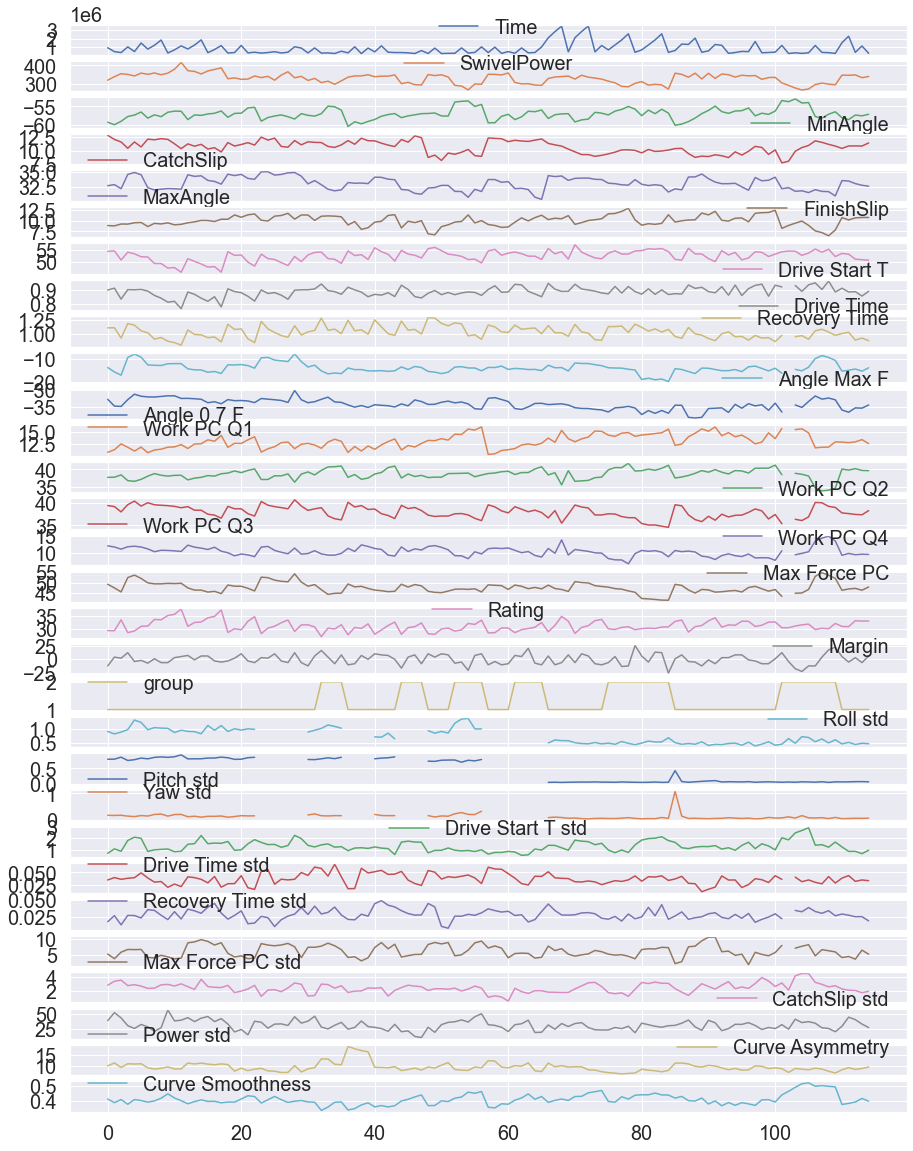

In [13]:
boat_avg.plot(subplots = True, figsize = (15,20))

In [14]:
# Drop Pitch std due to outliers 
boat_avg = boat_avg.drop(columns = ['Pitch std'])

# Feature Selection

In [45]:
#Take out NaN values 
boat_avg = boat_avg.fillna(boat_avg.median())

# ddefine x and y 
x = boat_avg.loc[:, boat_avg.columns != 'Margin']
y = boat_avg.Margin

**Run wrapper (backward elimination) to select features for each independent model**

source: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b 

**OLS/LASSO Regression**

In [16]:
### OLS/Lasso Regression ###

p_threshold = 0.05

cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = x[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1, missing='drop').fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>p_threshold):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_OLS = cols
print(selected_features_OLS)

['CatchSlip', 'FinishSlip', 'Work PC Q1', 'Work PC Q2', 'Work PC Q3', 'Work PC Q4', 'group']


**Decision Tree**

In [17]:
### Decision Tree ###
model = tree.DecisionTreeRegressor()
model.fit(x, y)

importance_threshold = 0.3

cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = x[cols]
    model =  tree.DecisionTreeRegressor().fit(X_1, y)
    p = pd.Series(model.feature_importances_,index = cols)      
    pmin = min(p)
    feature_with_p_min = p.idxmin()
    if(pmin < importance_threshold):
        cols.remove(feature_with_p_min)
    else:
        break
selected_features_TREE = cols
print(selected_features_TREE)

['SwivelPower', 'Work PC Q1']


**Extreme Gradient Boosted Tree**

In [18]:
### Boosted Tree ###
# create an xgboost regression model
model = XGBRegressor(n_estimators=1000, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(x, y)

importance_threshold = 0.125

cols = list(x.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = x[cols]
    model = XGBRegressor(n_estimators=1000, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(X_1, y)
    p = pd.Series(model.feature_importances_,index = cols)      
    pmin = min(p)
    feature_with_p_min = p.idxmin()
    if(pmin < importance_threshold):
        cols.remove(feature_with_p_min)
    else:
        break
selected_features_XGBTREE = cols
print(selected_features_XGBTREE)


['SwivelPower', 'FinishSlip', 'Angle Max F', 'Work PC Q1', 'Curve Smoothness']


**Neural Network** 

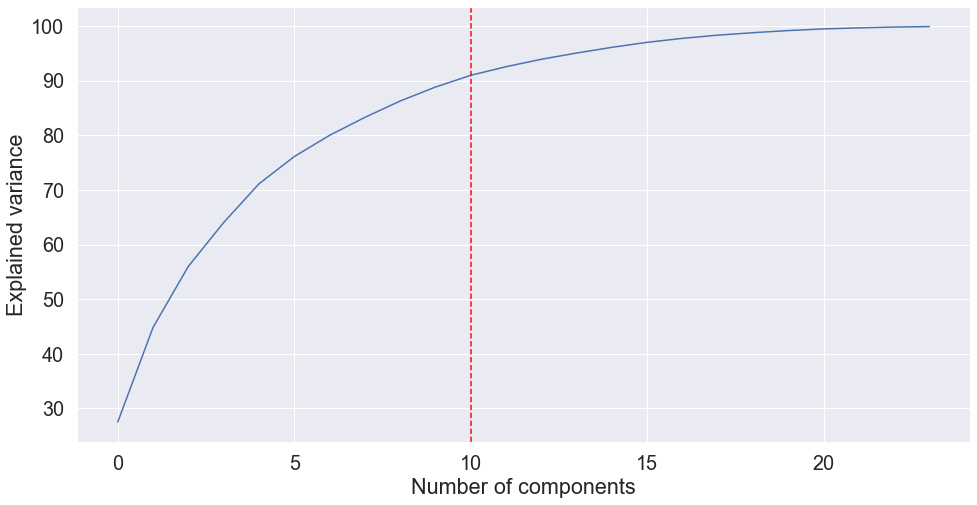

In [19]:
## Neural Network ## 
# Use Principle Component Analysis (PCA) !! did not work well !! --> use kbest

# scale features 
cols = list(x.columns)
mms = MinMaxScaler()
x_scaled = mms.fit_transform(boat_avg.loc[:, cols])

pca = PCA(n_components=24)
pca.fit(x_scaled)

# Plot 
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.axvline(x = 10, linestyle = '--', color = 'red')

In [20]:
selector = SelectKBest(r_regression, k=10)
x_kbest = pd.DataFrame(selector.fit_transform(x_scaled, y))

# Print features
idx = selector.get_support(indices = True)
x.columns[idx]

Index(['SwivelPower', 'MaxAngle', 'Recovery Time', 'Angle 0.7 F', 'Work PC Q3',
       'Work PC Q4', 'Max Force PC', 'Drive Time std', 'Max Force PC std',
       'Curve Asymmetry'],
      dtype='object')

# MODEL #1: OLS REGRESSION  

**Run Regression with selected variables**

In [21]:
# Run regression with (SKLEARN)
reg_selected = LinearRegression(fit_intercept = True).fit(x[selected_features_OLS], y)
reg_selected.score(x[selected_features_OLS], y)

0.23987945772870856

In [22]:
# Run regression with selected variables (STATSMODELS)
X_ols = sm.add_constant(x[selected_features_OLS])
model = sm.OLS(y, X_ols, missing='drop')
results = model.fit()
p = results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     4.824
Date:                Sun, 09 Apr 2023   Prob (F-statistic):           9.44e-05
Time:                        22:40:49   Log-Likelihood:                -402.17
No. Observations:                 115   AIC:                             820.3
Df Residuals:                     107   BIC:                             842.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.289e+04   9135.920     -2.506      0.0

Text(0, 0.5, 'Feature')

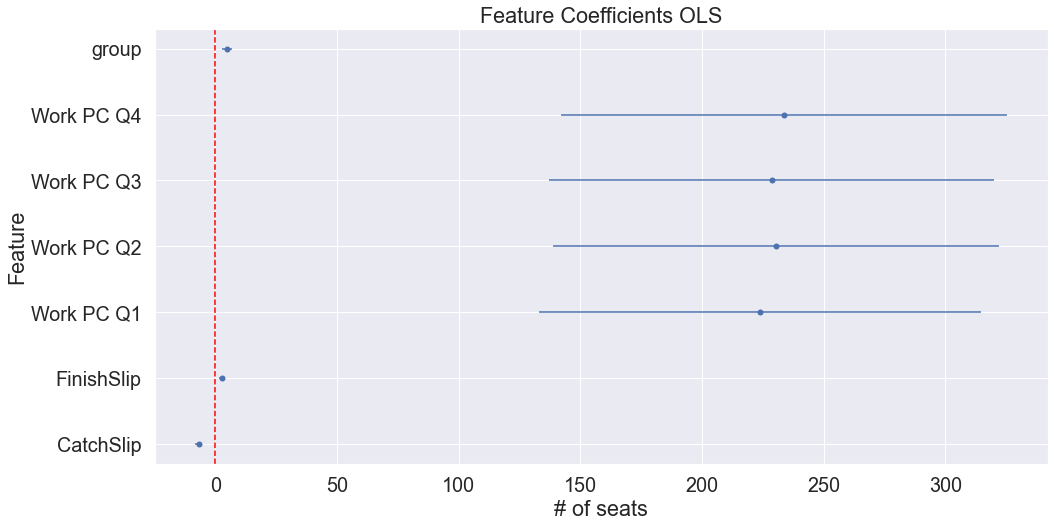

In [23]:
coef = results.params.drop(['const'])
stderr = results.bse.drop(['const'])
fig, ax = plt.subplots()
ax.errorbar(y = coef.index, x = coef, xerr = stderr, marker="o", linestyle="none")
ax.axvline( x = 0, color = 'red', linestyle='--')
plt.title('Feature Coefficients OLS')
plt.xlabel('# of seats'); plt.ylabel('Feature')

**Run Regression with all variables** 

In [24]:
# Run regression with (SKLEARN)
reg_all = LinearRegression(fit_intercept = True).fit(x, y)
reg_all.score(x, y)

0.35530896938257994

In [25]:
# Run regression with selected variables (STATSMODELS)
X_ols = sm.add_constant(x)
model = sm.OLS(y, X_ols, missing='drop')
results = model.fit()
p = results.params
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Margin   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     1.693
Date:                Sun, 09 Apr 2023   Prob (F-statistic):             0.0340
Time:                        22:40:50   Log-Likelihood:                -392.70
No. Observations:                 115   AIC:                             843.4
Df Residuals:                      86   BIC:                             923.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.598e+04   1.78e+0

# MODEL #2 LASSO REGRESSION

**Run Lasso with selected variables**

In [26]:
lasso_selected = linear_model.Lasso(alpha=0.1).fit(x[selected_features_OLS], y)
lasso_selected.score(x[selected_features_OLS], y)

0.18886959877816023

**Run Lasso with all variables**

In [27]:
lasso_all = linear_model.Lasso(alpha=0.1).fit(x, y)
lasso_all.score(x, y)

0.2731389316964049

# MODEL #3: DECISION TREE  

**Run Decision Tree with selected variables** 

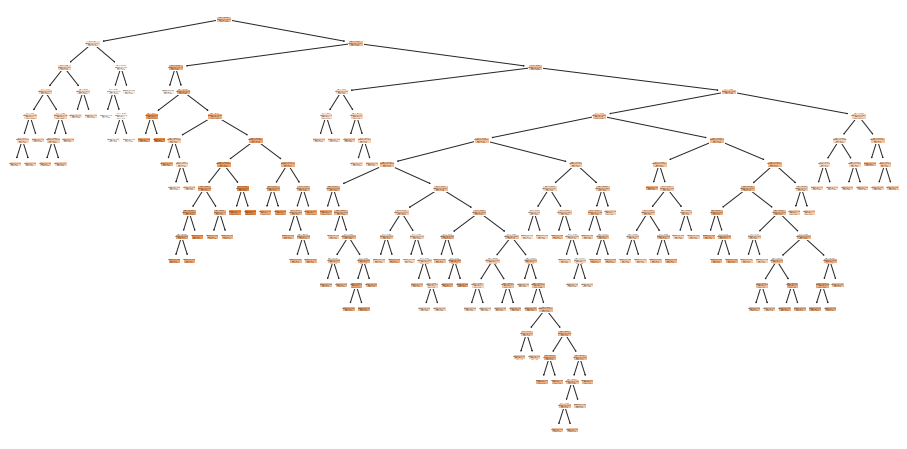

In [28]:
tree_selected = tree.DecisionTreeRegressor()
tree_selected.fit(x[selected_features_TREE], y)
# Plot tree
tree.plot_tree(tree_selected, filled = True)
plt.show()

**Run Decision tree with all variables**

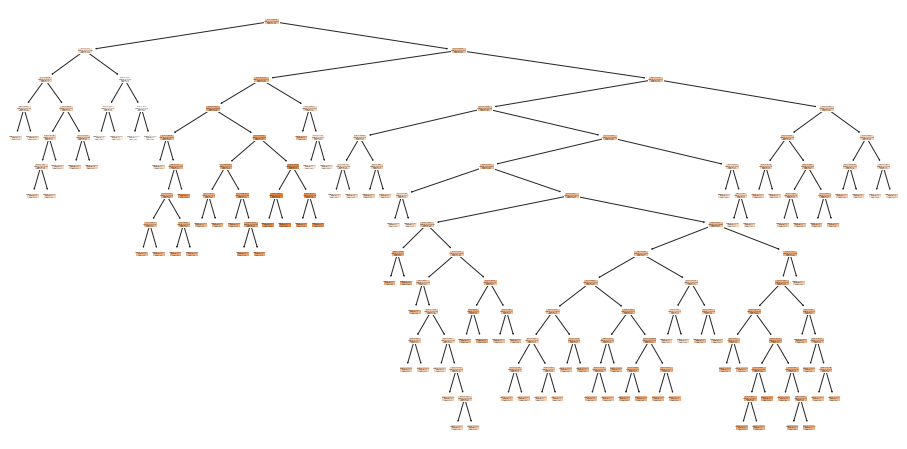

In [29]:
tree_all = tree.DecisionTreeRegressor()
tree_all.fit(x, y)
# Plot tree
tree.plot_tree(tree_all, filled = True)
plt.show()

# MODEL #4: EXTREME GRADIENT BOOSTED TREE 

**Run XGB Tree with selected variables**

<AxesSubplot:>

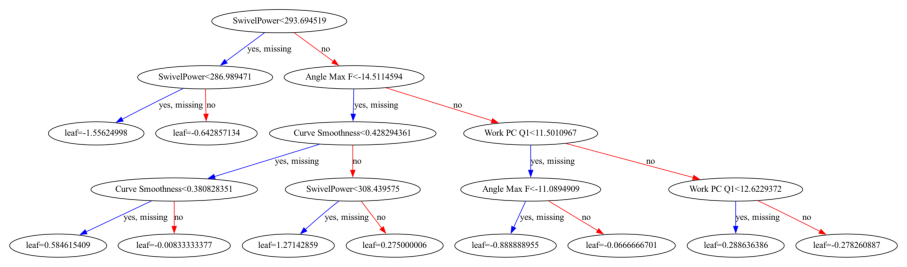

In [30]:
# create an xgboost regression model
xgb_tree_selected = XGBRegressor(n_estimators=1000, max_depth=4, eta=0.1, subsample=0.85, colsample_bytree=0.8)
xgb_tree_selected.fit(x[selected_features_XGBTREE], y)
# Plot tree
plot_tree(xgb_tree_selected)

**Run XGB Tree with all variables**

<AxesSubplot:>

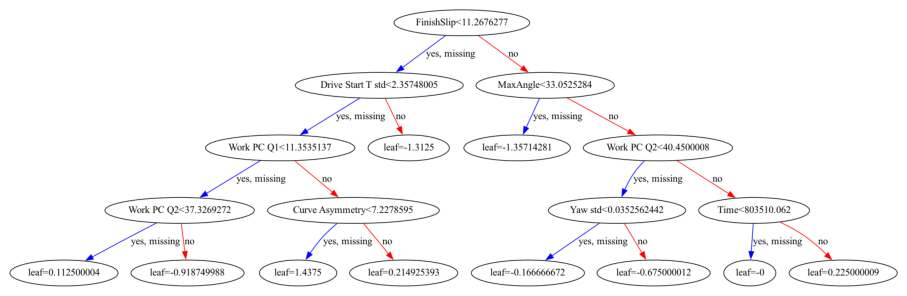

In [31]:
# create an xgboost regression model
xgb_tree_all = XGBRegressor(n_estimators=1000, max_depth=4, eta=0.1, subsample=0.85, colsample_bytree=0.8)
xgb_tree_all.fit(x, y)
# Plot tree
plot_tree(xgb_tree_all)

# MODEL #5 NEURAL NETWORK

**Prepare Data**
source: https://towardsdatascience.com/neural-feature-importance-1c1868a4bf53 

**Run Neural Network on selected variables**

In [32]:
nn_selected = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1, max_iter = 5000, activation='relu')
nn_selected.fit(x_kbest,y)

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(10, 2), max_iter=5000,
             random_state=1, solver='lbfgs')

**Run Neural Network on all variables**

In [33]:
nn_all = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10, 2), random_state=1, max_iter = 5000, activation='relu')
nn_all.fit(x,y)

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(10, 2), max_iter=5000,
             random_state=1, solver='lbfgs')

# Prediction Accuracy

In [34]:
def pred_accuracy(model, x, y): 
    # Predict MAE 
    cv = RepeatedKFold(n_splits=10, n_repeats=7, random_state=1)
    # evaluate model
    scores = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    MAE = abs(scores).mean()
    
    # Predict classification accuracy (win/loss)
    y_pred = cross_val_predict(model, x, y, cv = 5)
    outcomes = y * y_pred

    pred_accuracy = np.sum(np.array(outcomes) >= 0, axis=0)/len(y)
    return np.round(pred_accuracy, 2), np.round(MAE, 2)

In [35]:
%%capture
# Regression 
reg_score_selected = pred_accuracy(reg_selected,x[selected_features_OLS], y)
reg_score_all = pred_accuracy(reg_all,x, y)
# Lasso 
lasso_score_selected = pred_accuracy(lasso_selected,x[selected_features_OLS], y)
lasso_score_all = pred_accuracy(lasso_all,x, y)
# Decision Tree 
tree_score_selected = pred_accuracy(tree_selected,x[selected_features_TREE], y)
tree_score_all = pred_accuracy(tree_selected,x, y)
# XGB Tree 
xgb_tree_score_selected = pred_accuracy(xgb_tree_selected,x[selected_features_XGBTREE], y)
xgb_tree_score_all = pred_accuracy(xgb_tree_selected,x, y)
# Neural Network 
nn_score_selected = pred_accuracy(nn_selected,x_kbest, y)
nn_score_all = pred_accuracy(nn_all, x, y)

/Users/jelmerbennema/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e+02, tolerance: 8.456e-01
  model = cd_fast.enet_coordinate_descent(
/Users/jelmerbennema/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.799e+03, tolerance: 9.000e-01
  model = cd_fast.enet_coordinate_descent(


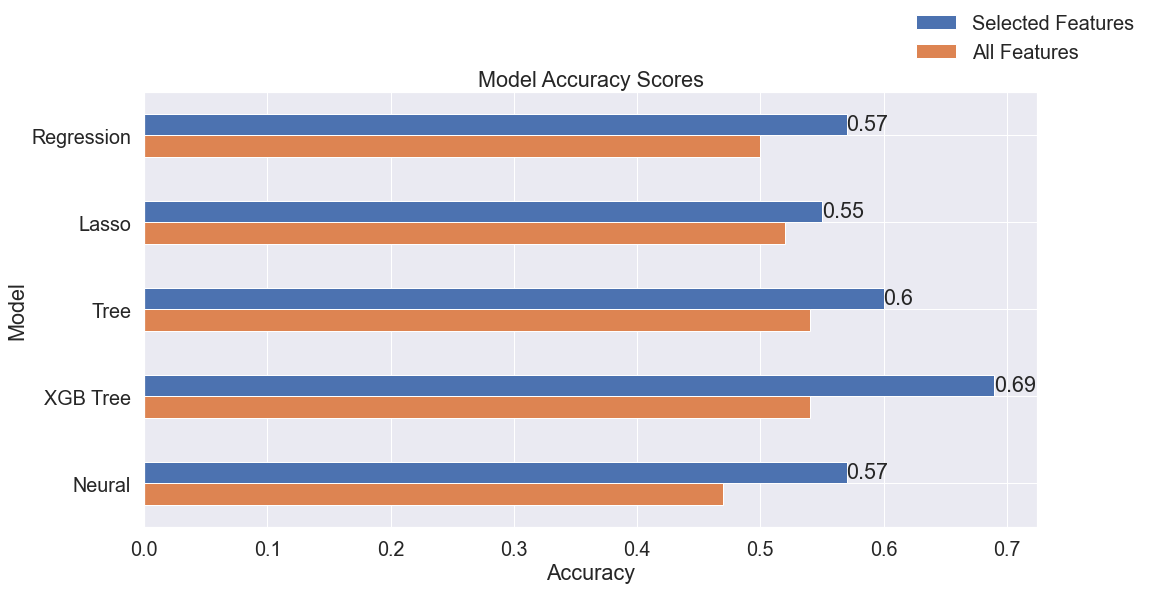

In [36]:
model_list = [('Regression', reg_score_selected[0], reg_score_all[0]),
              ('Lasso', lasso_score_selected[0], lasso_score_all[0]),
                ('Tree', tree_score_selected[0], tree_score_all[0]),
              ('XGB Tree', xgb_tree_score_selected[0], xgb_tree_score_all[0]),
              ('Neural', nn_score_selected[0], nn_score_all[0])] 

df = pd.DataFrame(model_list, columns=['Model', 'Selected Features', 'All Features'])
ax = df.plot(kind='barh', x='Model', title = 'Model Accuracy Scores')
# Add plot styling
ax.bar_label(ax.containers[0], label_type = 'edge')
ax.invert_yaxis()
plt.xlabel('Accuracy')
plt.legend(bbox_to_anchor=(1,0.9), loc="lower right", fontsize=20, 
           bbox_transform=plt.gcf().transFigure)

# Correlation Observations 

Text(0.5, 1.0, 'FinishSlip')

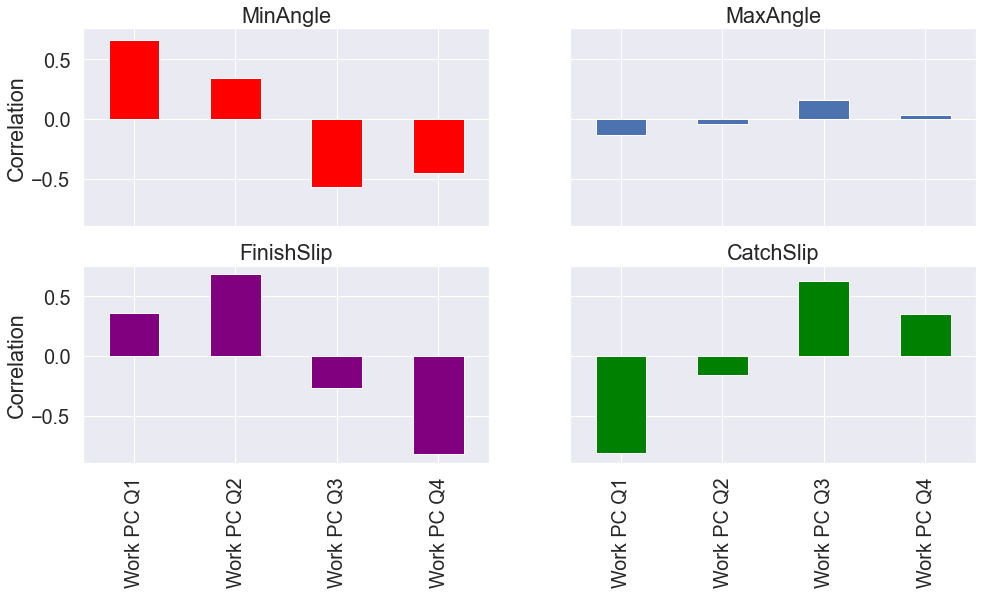

In [37]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
# MinAngle
plt.subplot(2,2,1)
corr['MinAngle'][['Work PC Q1', 'Work PC Q2', 'Work PC Q3', 'Work PC Q4']].plot(kind = 'bar', color = 'red')
plt.ylabel('Correlation');plt.title('MinAngle')
# MaxAngle 
plt.subplot(2,2,2)
corr['MaxAngle'][['Work PC Q1', 'Work PC Q2', 'Work PC Q3', 'Work PC Q4']].plot(kind = 'bar')
plt.title('MaxAngle')
# CatchSlip 
plt.subplot(2,2,4)
corr['CatchSlip'][['Work PC Q1', 'Work PC Q2', 'Work PC Q3', 'Work PC Q4']].plot(kind = 'bar', color = 'green')
plt.ylabel('Correlation'); plt.title('CatchSlip')
# FinishSlip 
plt.subplot(2,2,3)
corr['FinishSlip'][['Work PC Q1', 'Work PC Q2', 'Work PC Q3', 'Work PC Q4']].plot(kind = 'bar', color = 'purple')
plt.ylabel('Correlation'); plt.title('CatchSlip')
plt.title('FinishSlip')

# Force Curve Analysis

**Plot all powercurves**

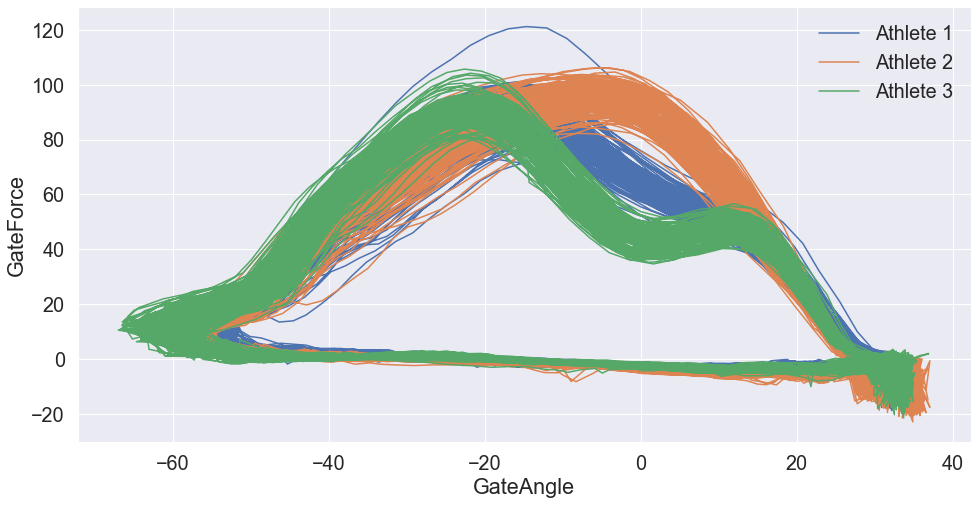

In [38]:
plt.plot( per['20_01_31_#1_b1'].GateAngle[4], per['20_01_31_#1_b1'].GateForceX[4], label = 'Athlete 1')
plt.plot( per['20_01_31_#1_b1'].GateAngle[5], per['20_01_31_#1_b1'].GateForceX[5], label = 'Athlete 2')
plt.plot( per['20_01_31_#1_b1'].GateAngle[1], per['20_01_31_#1_b1'].GateForceX[1], label = 'Athlete 3')
plt.xlabel('GateAngle'); plt.ylabel('GateForce'); plt.legend()

100%|█████████████████████████████████████████| 115/115 [00:02<00:00, 47.88it/s]


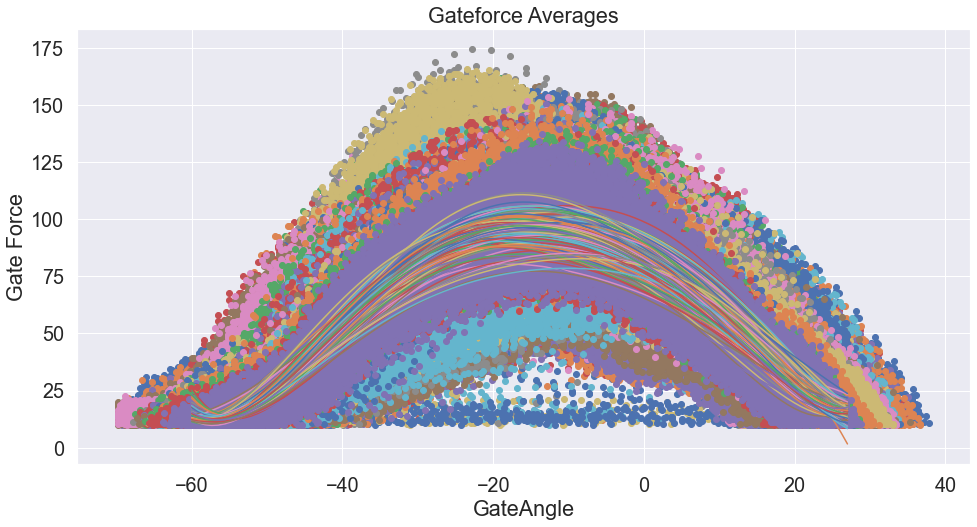

In [39]:
for datapoint in tqdm(range(0, 115)): 

    # Gather data 
    idx = np.where(per[sheets[datapoint]].GateForceX.to_numpy().flatten().astype(float) > 10)
    x = per[sheets[datapoint]].GateAngle.to_numpy().flatten().astype(float)[idx]
    y = per[sheets[datapoint]].GateForceX.to_numpy().flatten().astype(float)[idx]

    # outlier treatment (drop outliers from x and y)
    idx_nan = np.logical_and(x > -70, x < 50) & np.logical_and(y > -50, y < 190)
    x = x[idx_nan]; y = y[idx_nan]
    
    # run 7-degree polynomial
    mymodel = np.poly1d(np.polyfit(x, y, 7))
    myline = np.linspace(-60, 27, 100)

    #plot best fit 
    plt.scatter(x, y, label = 'GateForce points, 8 athletes, piece{0}'.format(datapoint))
    plt.plot(myline, mymodel(myline), label = 'average power curve')
    plt.xlabel('GateAngle'); plt.ylabel('Gate Force')
    plt.title('Gateforce Averages') 
 

**Plot average winning and losing powercurves** 

In [40]:
idx_win = np.where(boat_avg.Margin > 0)
idx_lose = np.where(boat_avg.Margin < 0)

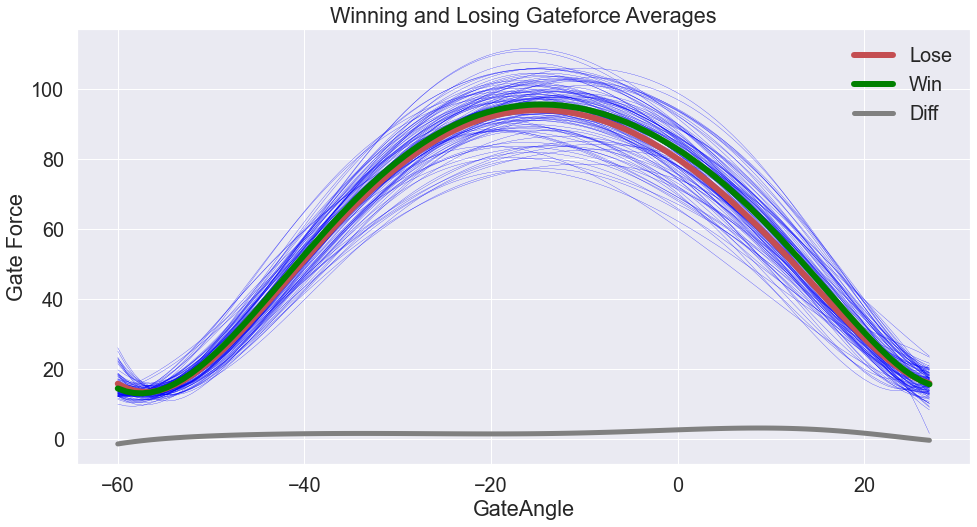

In [41]:
curve = np.zeros((115, 100))

for datapoint in range(0, 115): 

    idx = np.where(per[sheets[datapoint]].GateForceX.to_numpy().flatten().astype(float) > 10)
    x_ = per[sheets[datapoint]].GateAngle.to_numpy().flatten().astype(float)[idx]
    y_ = per[sheets[datapoint]].GateForceX.to_numpy().flatten().astype(float)[idx]

    # outlier treatment (drop outliers from x and y)
    idx_nan = np.logical_and(x_ > -70, x_ < 50) & np.logical_and(y_ > -50, y_ < 190)
    x_ = x_[idx_nan]; y_ = y_[idx_nan]
    
    # run 7-degree polynomial
    mymodel = np.poly1d(np.polyfit(x_, y_, 7))
    curve[datapoint] = mymodel(myline)
    
    #plot best fit 
    #plt.scatter(x, y, label = 'GateForce points, 8 athletes, piece{0}'.format(datapoint))
    plt.plot(myline, curve[datapoint], color = 'blue', lw = 0.25)
    plt.xlabel('GateAngle'); plt.ylabel('Gate Force')
    plt.title('Winning and Losing Gateforce Averages') 
    
# Plot average Curve 
plt.plot(myline, np.mean(curve[idx_lose[0]], axis=0) , color = 'r', linewidth = 6, label = 'Lose')
plt.plot(myline, np.mean(curve[idx_win[0]], axis=0) , color = 'green', linewidth = 6, label = 'Win')
plt.plot(myline, np.mean(curve[idx_win[0]], axis=0)-np.mean(curve[idx_lose[0]], axis=0) , color = 'grey', linewidth = 5, label = 'Diff')
plt.legend()

# Feature Importance

In [42]:
features = xgb_tree_selected.get_booster().get_score(importance_type="gain")

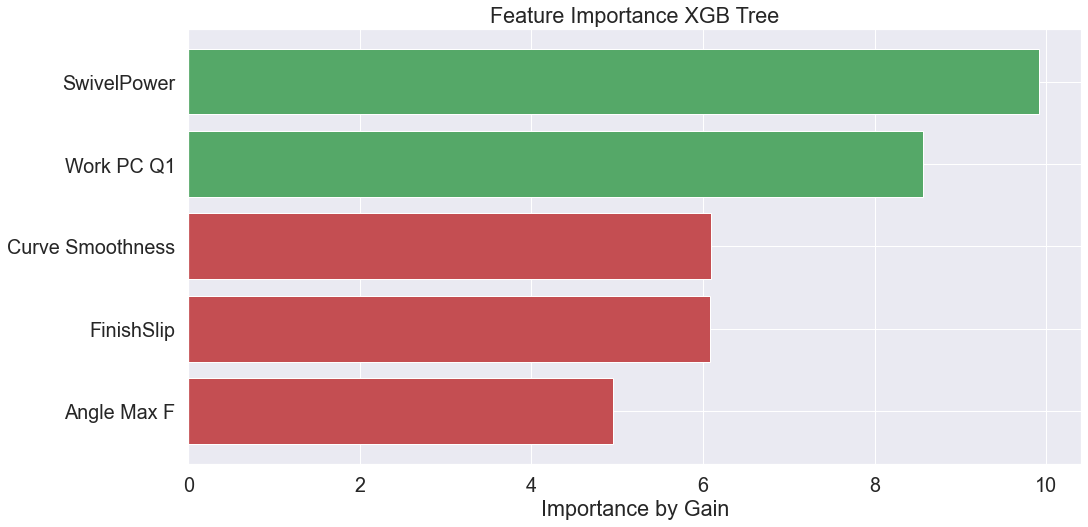

In [43]:
features_sorted = sorted(features, key=features.get,)
names = features_sorted
values = sorted(features.values())

colors = ['r','r','r','g', 'g']
plt.barh(range(len(features)), values, tick_label=names, color = colors)
plt.title('Feature Importance XGB Tree')
plt.xlabel('Importance by Gain')
plt.show()

In [46]:
xgb_tree_linear = XGBRegressor(n_estimators=1000, booster = 'gblinear')
coeff = xgb_tree_linear.fit(x[selected_features_XGBTREE], y).coef_
coeff

array([ 4.04536e-02, -1.81968e+00, -1.29159e-02,  7.71668e-02,
       -2.01001e+01])

In [47]:
xgb_tree_linear.fit(x[selected_features_XGBTREE], y).feature_names_in_

array(['SwivelPower', 'FinishSlip', 'Angle Max F', 'Work PC Q1',
       'Curve Smoothness'], dtype='<U16')